In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# EDA

In [23]:
X_train = np.load('./data (1)/training_x_grid.npy')
X_test = np.load('./data (1)/testing_x_grid.npy')
y_train = np.load('./data (1)/training_y.npy')

In [24]:
#training: (number of observation, height, width, feature)
number_of_features = X_train.shape[3]
print(X_train.shape, X_test.shape)
print(y_train.shape)

(8760, 30, 38, 13) (8760, 30, 38, 13)
(8760, 2)


(30, 38)


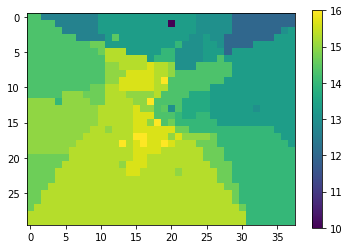

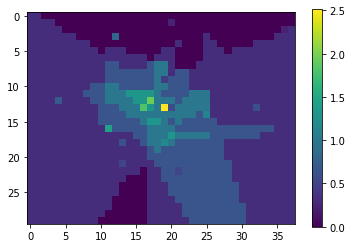

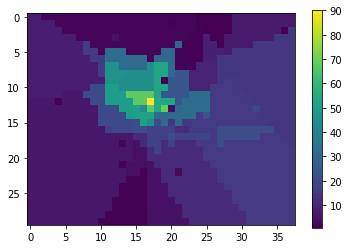

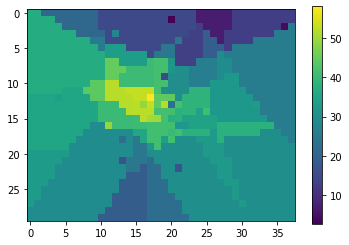

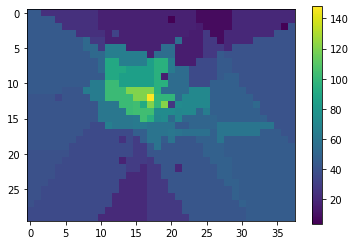

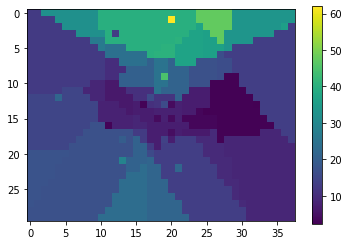

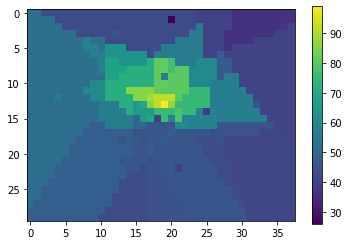

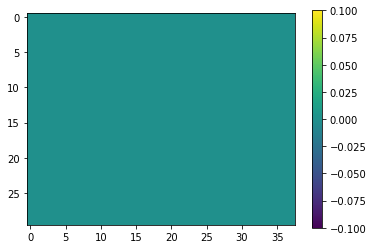

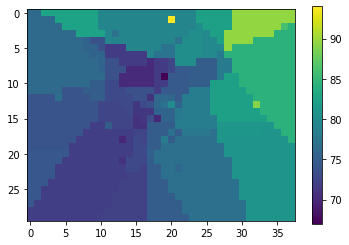

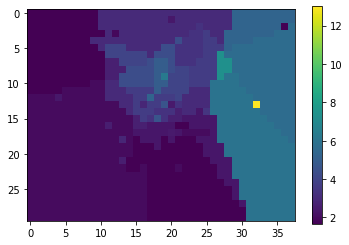

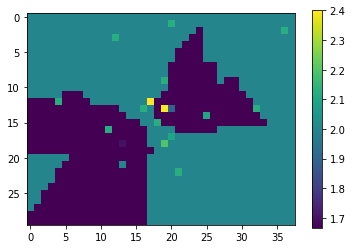

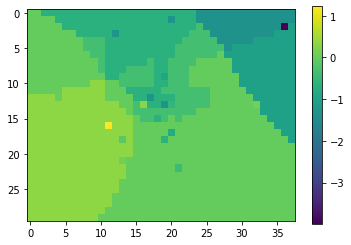

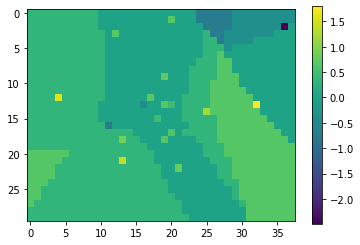

In [18]:
features = 0 #AMB_TEMP, CO, NO, NO2, NOx, O3, PM10, RAINFALL, RH, SO2, THC, cos_wind, sin_wind
image_shape = X_train[0,:,:,0].shape
print(image_shape)
for i in range(number_of_features):
    plt.imshow(X_train[0,:,:,i])
    plt.colorbar()
    plt.show()

# CNN

In [22]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
SEED = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

## Photo preprocessing

In [63]:
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
# img_tr = transform(X_train)
# img_np = np.array(X_train)
mean_img = np.mean(X_train, axis=tuple(range(0, 3)))
std_img = np.std(X_train, axis=tuple(range(0, 3)))
print(f"Mean of each channel is {mean_img}")
print(f"Std of each channel is {std_img}")

Mean of each channel is [ 2.29940176e+01  1.16575642e-01  7.47829880e+00  1.76970715e+01
  2.55730540e+01  2.92185379e+01  4.23096844e+01  2.14363958e-01
  7.50016315e+01  2.81763435e+00  1.28958399e+00 -9.03108535e-03
  7.08277692e-01]
Std of each channel is [ 6.05780731  0.28256565 11.65424577 10.31597383 19.30278588 18.0803279
 22.73653019  1.42130498 12.38884299  2.22243181  0.39840187  0.7309027
  1.29507284]


## Build Dataset and Dataloader

In [30]:
class WeatherTrainingDataset(Dataset):
    def __init__(self, X, y, augment = None):
        self.X = X
        self.y = y
        self.augment = augment
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.augment is not None:
            img = self.augment(self.X[idx])
        else:
            img = self.X[idx]
        label = self.y[idx]
        return img, label

class WeatherTestingDataset(Dataset):
    def __init__(self, X, augment = None):
        self.X = X
        self.augment = augment
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.augment is not None:
            img = self.augment(self.X[idx])
        else:
            img = self.X[idx]
        return img

In [43]:
test_torch = torch.from_numpy(X_train[:2, :, :, :])

In [45]:
conv = nn.Conv2d(1, 64, kernel_size=5, padding=2)
out = conv(test_torch)
out.shape()

RuntimeError: Given groups=1, weight of size [64, 1, 5, 5], expected input[2, 30, 38, 13] to have 1 channels, but got 30 channels instead

In [ ]:
class WeatherRegrssionNet(nn.Module):
    def __init__(self):
        super(WeatherRegrssionNet, self).__init__()

        ###########################general information###########################
        self.conv1_out_channels = 64
        self.leakyReLU1_slope = 0.05
        self.conv1_dropout_rate = 0.2

        self.conv0 = nn.Sequential(
            nn.Conv2d(1, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.Dropout2d(0.2)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, self.conv1_out_channels, kernel_size=5, padding=2),
            nn.LeakyReLU(negative_slope=self.leakyReLU1_slope),
            nn.BatchNorm2d(self.conv1_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )

        #########################location information######################
        self.conv2_out_channels = 512
        self.leakyReLU2_slope = 0.05
        self.conv2_dropout_rate = 0.5
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.conv1_out_channels, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, self.conv2_out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(self.conv2_out_channels, self.conv2_out_channels, kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=self.leakyReLU2_slope),
            nn.BatchNorm2d(self.conv2_out_channels),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5)
        )

        #######################Fully connected layer########################
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.conv2_out_channels, self.conv2_out_channels),
            nn.ReLU(),
            nn.BatchNorm1d(self.conv2_out_channels),
            nn.Dropout(0.5)
        )
        self.fc3 = nn.Linear(self.conv2_out_channels, 7)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 4*4*self.conv2_out_channels)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# RNN

In [ ]:
#最簡單的範例，(知道timedistributed的可以直接合成CNN+RNN為一個模型)
#CNN (8760,30,38,10) - > (8760, 2)
#先train一個CNN模型來預測PM2.5，輸出為(8760,2), 命名為 training_pred
#用CNN模型最佳的weight來預測testing資料，輸出為(8760,2), 命名為testing_pred


timestep = 8
training_pred_rnn, testing_pred_rnn = ([] for _ in range(2))

for i in range(training_grid.shape[0]-timestep):
    training_pred_rnn.append(training_pred[i:i+timestep])
    testing_pred_rnn.append(testing_pred[i:i+timestep])
training_pred_rnn = np.array(training_pred_rnn)
testing_pred_rnn = np.array(testing_pred_rnn)
training_y_rnn = y[timestep:] #(8760,2) - > (8752,2)
    
print(training_rnn.shape, testing_rnn.shape) #(8752,8,2)

history = rnn_model.fit(training_rnn, training_y_rnn....)
rnn_model.load_weights(...)
y_hat = rnn_model.predict(testing_rnn)